<a href="https://colab.research.google.com/github/Tonge-Shim/1/blob/master/mnist_used.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pandas import DataFrame
warnings.filterwarnings(action='ignore')
sns.set()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df= pd.read_csv('samp_cst_feat.csv')
dtype = pd.read_excel('variable_dtype.xlsx')
dtype_categ = dtype[(dtype['dType']=='categorical')]
dtype_numrc = dtype[(dtype['dType']=='numerical')]
numrc_var = dtype_numrc['Variable_Name']
categ_var = dtype_categ['Variable_Name']
numrc_var = numrc_var.values.tolist()
categ_var = categ_var.values.tolist()#0,1
x=df.drop(categ_var, axis=1).drop(['cst_id_di'],axis=1)#10124개
y=pd.read_csv('samp_train.csv').drop(['cst_id_di'],axis=1)#10124
y_nozero= y[(y['MRC_ID_DI']!=0)]#not 0!!!1924
#y_nozeroindex=y_nozero.loc[1:10119]
y_nozeroindexlist=y_nozero.index.tolist()
x_nozero=x.loc[y_nozeroindexlist]

In [3]:
print(x_nozero.shape)
print(y_nozero.shape)
print(x.shape)
print(y.shape)
y_nozeroarray=y_nozero.to_numpy()#1924
y_array=y.to_numpy()#10124
x_nozeroarray=x_nozero.to_numpy()#1924
x_array=x.to_numpy()#10124

(1924, 198)
(1924, 1)
(10124, 198)
(10124, 1)


In [8]:
some_digit=x_nozeroarray[9]
print(y_nozeroarray[9])

[6]


#1924, 0이 없는 데이터셋

In [4]:
x_train, x_test, y_train, y_test=x_nozeroarray[:1400], x_nozeroarray[1400:], y_nozeroarray[:1400], y_nozeroarray[1400:]

In [5]:
shuffle_index=np.random.permutation(1400)
x_train, y_train=x_train[shuffle_index], y_train[shuffle_index]

In [6]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(max_iter=5, random_state=42)

In [9]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([7])

In [10]:
some_digit_scores=sgd_clf.decision_function([some_digit])
some_digit_scores#가장 높은 점수의 클래스를 반환

array([[-20.61605481, -17.90549848, -16.36019876, -18.20144219,
        -23.56893517, -14.41366625,  -5.98308051, -20.70512139,
        -26.73962927, -39.86461725]])

sgd classifier기반 ovo전략을 사용하는 다중 분류기
(one vs one classifier)

In [11]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf=OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict([some_digit])

array([7])

랜덤 포레스트 분류기

In [12]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
forest_clf.fit(x_train, y_train)
forest_clf.predict([some_digit])

array([6])

In [13]:
forest_clf.predict_proba([some_digit])#6으로 분류 될 확률이 0.73, 73%

array([[0.02, 0.  , 0.  , 0.  , 0.01, 0.72, 0.15, 0.09, 0.01, 0.  ]])

sgdclassifier의 정확도 평가

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.25481799, 0.40899358, 0.38841202])

In [15]:
cross_val_score(forest_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.43040685, 0.40685225, 0.43991416])

In [16]:
cross_val_score(ovo_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.33832976, 0.41755889, 0.36051502])

결론;;;랜덤 포레스트의 정확도가 가장 높은 상태...
성능을 더 높일 여지: 간단하게 입력의 스케일을 조정하면 정확도를 높일 수 있다.

In [17]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train.astype(np.float64))
print(cross_val_score(sgd_clf,x_train_scaled, y_train, cv=3, scoring="accuracy"))
print(cross_val_score(forest_clf,x_train_scaled, y_train, cv=3, scoring="accuracy"))
print(cross_val_score(ovo_clf,x_train_scaled, y_train, cv=3, scoring="accuracy"))

[0.35974304 0.40471092 0.33261803]
[0.4261242  0.40685225 0.43991416]
[0.3490364  0.40685225 0.38412017]


결론적으로 랜덤포레스트를 사용했을 때, 최고 정확도 42퍼센트가 나옴.

#에러분석

In [47]:
y_train_pred=cross_val_predict(sgd_clf, x_train_scaled, y_train,cv=3)
conf_mx=confusion_matrix(y_train, y_train_pred)
conf_mx

array([[  9,   0,   0,   0,   1,  23,  14,  12,   1,   0],
       [  0,   0,   0,   0,   0,   3,   6,   0,   1,   2],
       [  0,   0,   0,   1,   3,   5,  10,   0,   1,   0],
       [  0,   0,   0,   0,   0,   3,   3,   0,   0,   0],
       [  3,   0,   1,   1,  24,  24,  43,   5,   1,   6],
       [ 24,   0,   3,   3,  15, 138, 120,  76,   9,  10],
       [  2,   2,   8,   2,  27, 106, 278,  41,   2,  20],
       [ 23,   0,   2,   2,   7,  87,  63,  59,   5,   1],
       [  0,   0,   1,   0,   1,  11,  16,   5,   2,   4],
       [  0,   0,   0,   0,   0,   3,  10,   1,   3,   2]])

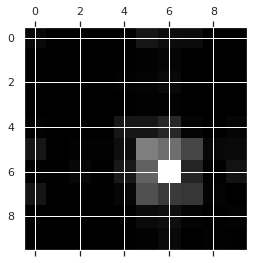

In [48]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()
#올바르게 분류되었을 때는 주 대각선에 있는데...얘는 안 그렇네?

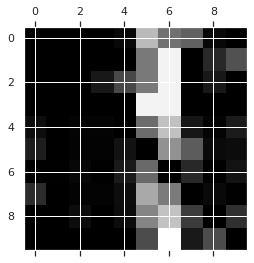

MRC_ID_DI
7            661
6            554
8            337
5            143
1             85
9             59
3             32
10            28
2             14
4             11
dtype: int64

In [53]:
#오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나눠 에러 비율을 비교
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
y_nozero.value_counts()#여기서 그림이랑 valuecounts를 비교하면 6,7에 편향되어 있음을 알 수 있다
#.많은 데이터가 6과 7로 잘못 분류되었음을 암시하는것.

#10124 all datasets

In [18]:
X_train, X_test, Y_train, Y_test=x_array[:8000], x_array[8000:], y_array[:8000], y_array[8000:]

In [34]:
shuffle_index=np.random.permutation(8000)
X_train, Y_train=X_train[shuffle_index], Y_train[shuffle_index]
some_digit=x_array[0]
print(y_array[0])

[0]


In [23]:
sgd_clf.fit(X_train, Y_train)
sgd_clf.predict([some_digit])

array([0])

In [21]:
ovo_clf.fit(X_train, Y_train)
ovo_clf.predict([some_digit])
#정답이 안나옴

array([7])

In [22]:
forest_clf.fit(X_train, Y_train)
forest_clf.predict([some_digit])

array([0])

In [24]:
forest_clf.predict_proba([some_digit])

array([[0.54, 0.01, 0.03, 0.03, 0.01, 0.07, 0.07, 0.14, 0.08, 0.02, 0.  ]])

In [150]:
print(cross_val_score(sgd_clf,X_train, Y_train, cv=3, scoring="accuracy"))
print(cross_val_score(forest_clf,X_train, Y_train, cv=3, scoring="accuracy"))
print(cross_val_score(ovo_clf,X_train, Y_train, cv=3, scoring="accuracy"))
#이 결과는...0이 많은 결과인 듯하다. 그럼 패쓰

[0.79265092 0.77690289 0.74568642]
[0.80727409 0.80914886 0.8072018 ]
[0.70228721 0.80164979 0.79107277]


#0과 0이 아닌 이진 분류

In [29]:
Y_train_0=(Y_train==0)#0은 true, 0이 아니면 false
Y_test_0=(Y_test==0)
sgd_clf.fit(X_train, Y_train_0)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [35]:
sgd_clf.predict([some_digit])

array([ True])

성능측정

In [37]:
cross_val_score(sgd_clf, X_train, Y_train_0, cv=3, scoring="accuracy")
#별로 선호하지 않는 성능 측정 지표; 특히, 불균형한 데이터셋을 다룰 때.

array([0.77877765, 0.59767529, 0.7228057 ])

In [41]:
from sklearn.model_selection import cross_val_predict
Y_train_pred=cross_val_predict(sgd_clf, X_train, Y_train_0, cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train_0, Y_train_pred)
from sklearn.metrics import precision_score, recall_score
print(precision_score(Y_train_0, Y_train_pred))
print(recall_score(Y_train_0, Y_train_pred))

0.9478798586572438
0.6646020439764633


0으로 판별된 이미지 중 94%가 정확하고, 전체 숫자 0에서 66%를 감지. 이 정도면 괜찮짛ㅎ
충분히 높고 괜찮은 분류기이기 때문에 임곗값이고 뭐고 바꿀 필요가 없음

In [42]:
from sklearn.metrics import f1_score
f1_score(Y_train_0, Y_train_pred)#f1점수는 정밀도와 재현율의 조화평균

0.78135809211724